This jupyter notebook is used to compare 2 models namely Logistic regression and XGBoost in credit card fraud detection the dataset is used from mongodb database collection and XGBoost has higher accuracy and is more accurate compared to logistic regression

c:\Users\AKSHAJA\OneDrive\Desktop\CreditCardFraud\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\AKSHAJA\OneDrive\Desktop\CreditCardFraud\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔍 Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1905
           1       0.96      0.96      0.96      1895

    accuracy                           0.96      3800
   macro avg       0.96      0.96      0.96      3800
weighted avg       0.96      0.96      0.96      3800



c:\Users\AKSHAJA\OneDrive\Desktop\CreditCardFraud\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:53:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🚀 XGBoost Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1905
           1       0.99      0.99      0.99      1895

    accuracy                           0.99      3800
   macro avg       0.99      0.99      0.99      3800
weighted avg       0.99      0.99      0.99      3800



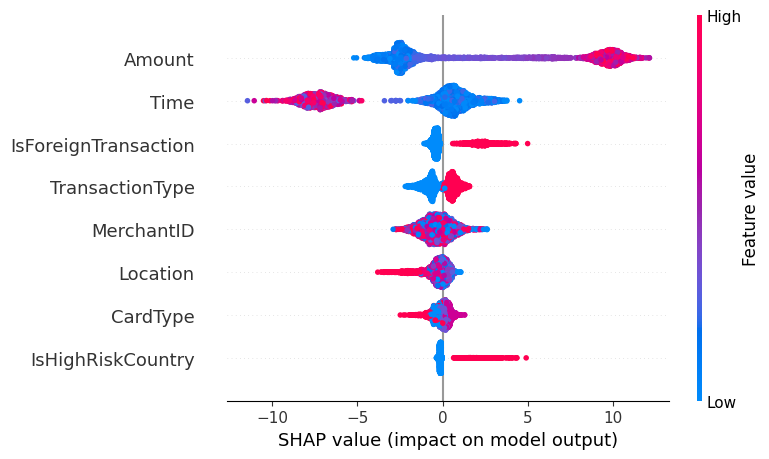

In [ ]:
from pymongo import MongoClient
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import shap


client = MongoClient("mongodb://localhost:27017/")
db = client["creditcard_db"]  
collection = db["transactions"]  


data = pd.DataFrame(list(collection.find()))


if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)


label_cols = ['MerchantID', 'Location', 'CardType', 'TransactionType']
le = LabelEncoder()
for col in label_cols:
    data[col] = le.fit_transform(data[col])


X = data.drop('IsFraud', axis=1)
y = data['IsFraud']


smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_lr))


xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\n XGBoost Report:\n", classification_report(y_test, y_pred_xgb))


explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)  


In [ ]:
import os
import pandas as pd
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)


MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "creditcard_db"
COLLECTION_NAME = "transactions"


client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]
df = pd.DataFrame(list(collection.find()))
print("Data loaded from MongoDB")


df.drop(columns=['_id'], inplace=True)


y = df['IsFraud']
X = df.drop(columns=['IsFraud'])


high_card_cols = ['MerchantID']
target_encoder = TargetEncoder(cols=high_card_cols)
X[high_card_cols] = target_encoder.fit_transform(X[high_card_cols], y)


low_card_cols = ['Location', 'CardType', 'TransactionType']
X = pd.get_dummies(X, columns=low_card_cols, drop_first=True)


joblib.dump(X.columns.tolist(), "models/feature_columns.pkl")


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f"Class distribution before SMOTE: {y_train.value_counts().to_dict()}")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
print(f"Class distribution after SMOTE: {pd.Series(y_train_bal).value_counts().to_dict()}")


xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)


y_pred = xgb_model.predict(X_test_scaled)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.savefig("plots/xgb_feature_importance.png")
plt.close()


joblib.dump(xgb_model, "models/xgb_fraud_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(target_encoder, "models/target_encoder.pkl")
print(" Model, scaler, and encoder saved.")


lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_bal, y_train_bal)


y_pred_lr = lr_model.predict(X_test_scaled)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])

print(f"\n Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f" Logistic Regression ROC-AUC: {lr_roc_auc:.4f}")


xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])

print(f"\n XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f" XGBoost ROC-AUC: {xgb_roc_auc:.4f}")


plt.figure(figsize=(10, 6))


fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {lr_roc_auc:.2f})")


fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("plots/roc_comparison.png")
plt.close()


joblib.dump(lr_model, "models/lr_fraud_model.pkl")
print(" Logistic Regression model saved.")

✅ Data loaded from MongoDB
Class distribution before SMOTE: {0: 985474, 1: 51866}
Class distribution after SMOTE: {0: 985474, 1: 985474}


c:\Users\AKSHAJA\OneDrive\Desktop\CreditCardFraud\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [13:10:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    246368
           1       0.75      0.96      0.84     12967

    accuracy                           0.98    259335
   macro avg       0.87      0.97      0.92    259335
weighted avg       0.99      0.98      0.98    259335


🔍 Confusion Matrix:
[[242191   4177]
 [   481  12486]]
✅ Model, scaler, and encoder saved.

📈 Logistic Regression Accuracy: 0.9715
📈 Logistic Regression ROC-AUC: 0.9956

📈 XGBoost Accuracy: 0.9820
📈 XGBoost ROC-AUC: 0.9972
✅ Logistic Regression model saved.


<Figure size 1000x600 with 0 Axes>